Iñigo Martin Melero

## Participante 4

Hacemos a lo que se refieren algunos papers. Nuestros datos de entrada son:

- Fisiológico: 2500000 elementos, medido milisegundo a milisegundo. 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10...
- Joystick: 40000 elementos, medido de 50 milisegundos en 50 milisegundos. 0, 50, 100, 150...

Cambiaremos los dataset de entrada para partir en igualdad de condiciones a los papers.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy import signal
from scipy import pi
from scipy.fftpack import rfft, rfftfreq

Leemos el csv del Joystick, y lo representamos.

In [2]:
df1=pd.read_csv('Bruto/sub_4_annotations.csv')
df1=df1.rename(columns={"jstime": "time"})
print(df1)

          time  valence  arousal  video
0            0      5.0      5.0     10
1           50      5.0      5.0     10
2          100      5.0      5.0     10
3          150      5.0      5.0     10
4          200      5.0      5.0     10
...        ...      ...      ...    ...
49027  2451350      5.0      5.0     12
49028  2451400      5.0      5.0     12
49029  2451450      5.0      5.0     12
49030  2451500      5.0      5.0     12
49031  2451550      5.0      5.0     12

[49032 rows x 4 columns]


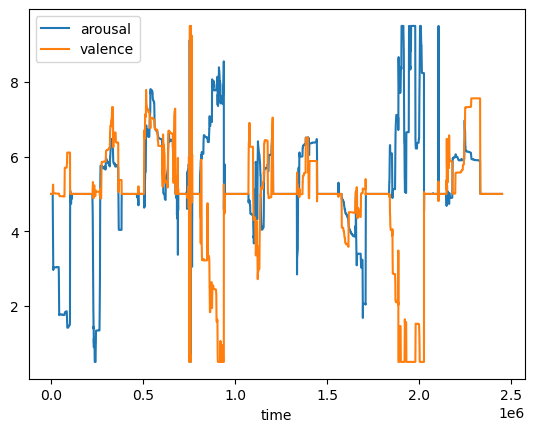

In [3]:
df1.plot(x="time", y=["arousal","valence"])
plt.show()

Leemos el csv de las variables Fisiológicas, y las representamos.

In [4]:
df2=pd.read_csv('Bruto/sub_4_physiological.csv')
df2=df2.rename(columns={"daqtime": "time"})
length_orig_df2=len(df2)
print(df2)

            time    ecg     bvp     gsr     rsp     skt  emg_zygo  emg_coru  \
0              0  1.030  36.535  32.610  33.641  27.770     7.987     7.124   
1              1  1.043  36.612  32.559  33.621  27.766     7.946     7.083   
2              2  1.053  36.297  32.679  33.640  27.780     7.986     7.164   
3              3  1.047  36.437  32.466  33.669  27.777     8.108     7.206   
4              4  1.043  36.554  32.608  33.650  27.766     8.109     7.084   
...          ...    ...     ...     ...     ...     ...       ...       ...   
2451579  2451579  1.247  31.652  31.679  35.054  26.431     5.771     7.452   
2451580  2451580  1.175  31.635  31.730  35.140  26.476     5.972     7.574   
2451581  2451581  1.126  31.759  31.722  35.064  26.421     5.933     7.454   
2451582  2451582  1.005  31.454  31.738  35.063  26.441     5.811     7.412   
2451583  2451583  0.958  31.661  31.703  35.092  26.438     5.932     7.452   

         emg_trap  video  
0          11.641     10

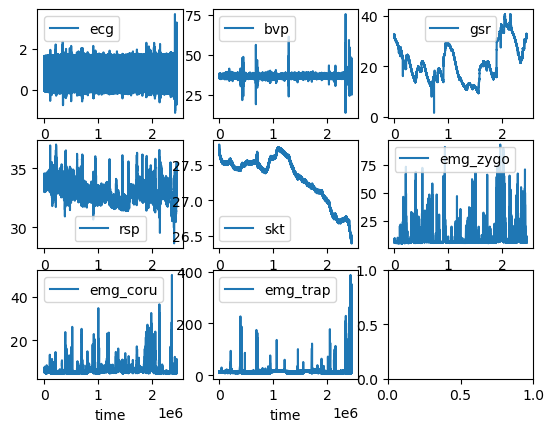

In [5]:
#define subplot layout
fig, axes = plt.subplots(nrows=3, ncols=3)

#add DataFrames to subplots
df2.plot(ax=axes[0,0],x="time",y="ecg")
df2.plot(ax=axes[0,1],x="time",y="bvp")
df2.plot(ax=axes[0,2],x="time",y="gsr")
df2.plot(ax=axes[1,0],x="time",y="rsp")
df2.plot(ax=axes[1,1],x="time",y="skt")
df2.plot(ax=axes[1,2],x="time",y="emg_zygo")
df2.plot(ax=axes[2,0],x="time",y="emg_coru")
df2.plot(ax=axes[2,1],x="time",y="emg_trap")
plt.show()

<AxesSubplot:xlabel='time'>

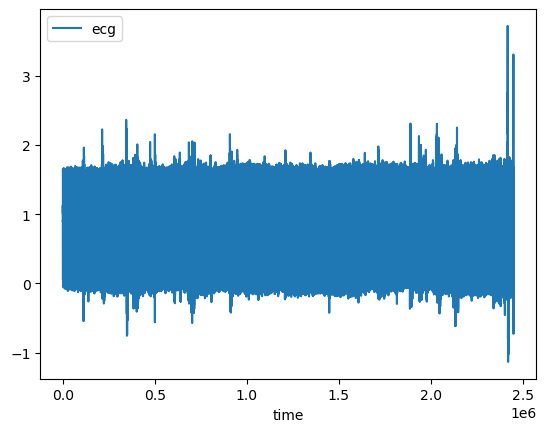

In [6]:
df2.plot(x="time",y="ecg")

<AxesSubplot:xlabel='time'>

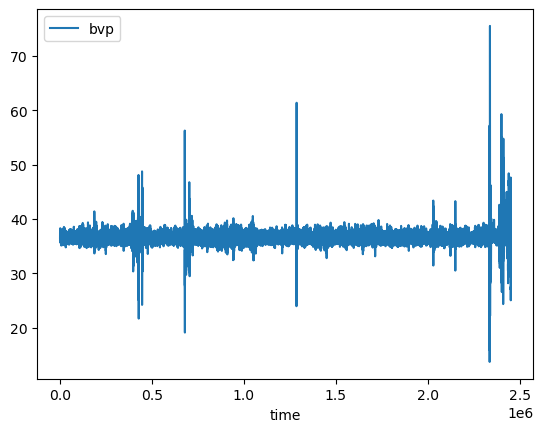

In [7]:
df2.plot(x="time",y="bvp")

<AxesSubplot:xlabel='time'>

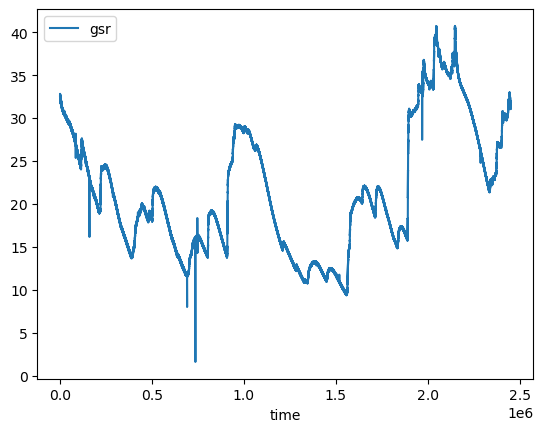

In [8]:
df2.plot(x="time",y="gsr")

<AxesSubplot:xlabel='time'>

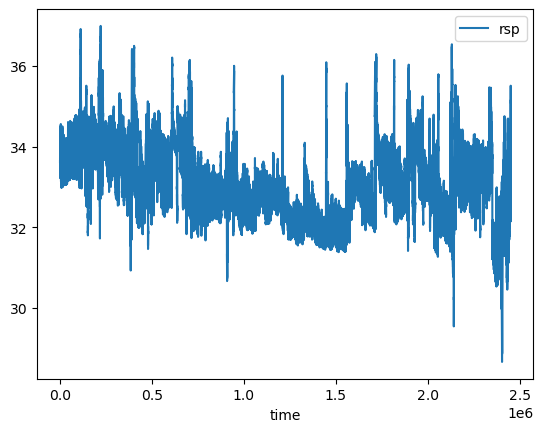

In [9]:
df2.plot(x="time",y="rsp")

<AxesSubplot:xlabel='time'>

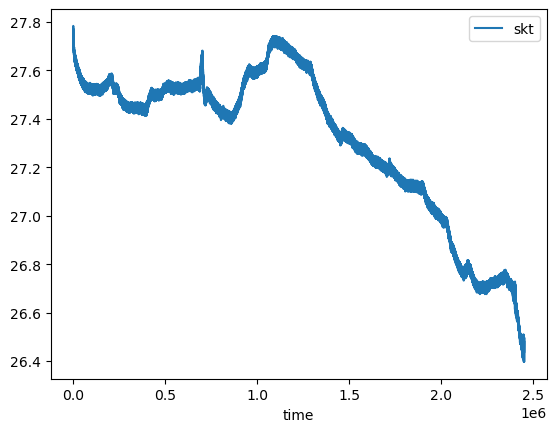

In [10]:
df2.plot(x="time",y="skt")


<AxesSubplot:xlabel='time'>

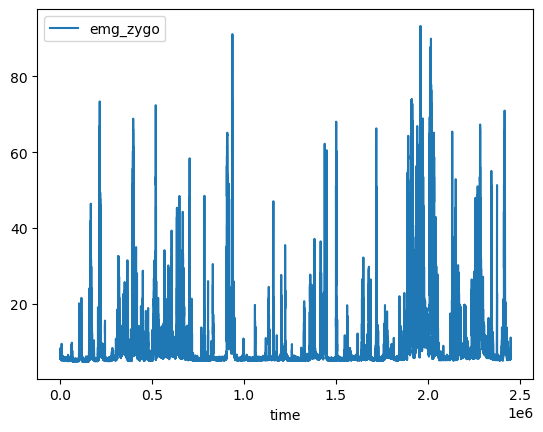

In [11]:
df2.plot(x="time",y="emg_zygo")


<AxesSubplot:xlabel='time'>

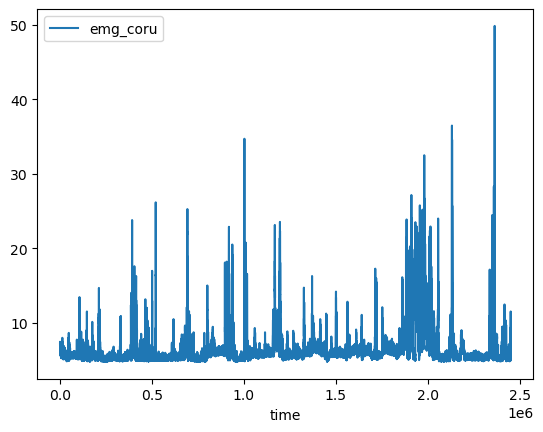

In [12]:
df2.plot(x="time",y="emg_coru")

<AxesSubplot:xlabel='time'>

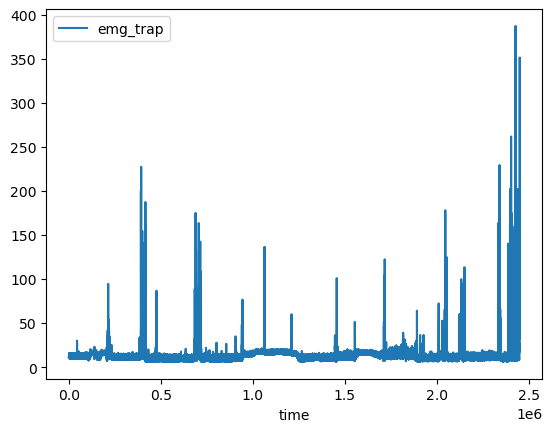

In [13]:
df2.plot(x="time",y="emg_trap")

El paper más completo que trata esto es CorrNet, donde se hace:

"Since the sampling rates of V-A and signals are 20 and 1000 Hz
respectively, we down-sampled all the signals to 50 Hz by decimation down-sampling. The EDA signals were
first filtered using a low pass filter with a 2 Hz cutoff frequency to remove noise.
For the BVP signal, we pre-processed it with a four-order butterworth bandpass filter with
cutoff frequencies [30, 200] Hz to eliminate the bursts. An elliptic band-pass filter
with cutoff frequencies [0.005, 0.1] was used to filter the ST signal. We followed the
standard filtering procedure widely used in previous works to pre-process the
physiological signals. Then the filtered signals are segmented into 2-second (sample size:
100 for CASE) instances."

O sea:

A) Se pasa filtro paso bajo 2 Hz a señales EDA (GSR).

B) Se pasa filtro de cuarto orden butterworth con frecuencias corte [30, 200] Hz a señal BVP.

C) Se utiliza un filtro de paso eliptico con frecuencias corte [0.005, 0.1] a señal ST (SKT).

D) Se normalizan las señales a 0 - 1, segun Min - Max.

E) Se busca la frecuencia en común de ambos a 50 Hz. Se hizo un estudio y fue la solución de compromiso.

F) Se utilizan ventanas de 2 segundos.

Lo vamos haciendo poco a poco.

    A) Se pasa filtro paso bajo 2 Hz a señales EDA (GSR).

<AxesSubplot:>

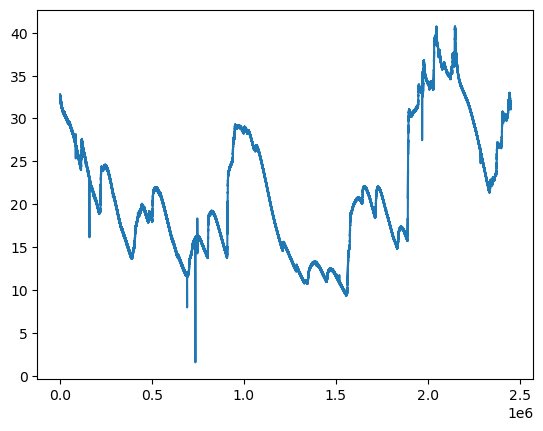

In [14]:
gsr_signal_notfiltered=df2['gsr']
gsr_signal_notfiltered.plot()

Representamos la senal en el dominio de la frecuencia. Vemos que hay frecuencias hasta el 500. Las querremos quitar todas menos las menores a 2 Hz. 

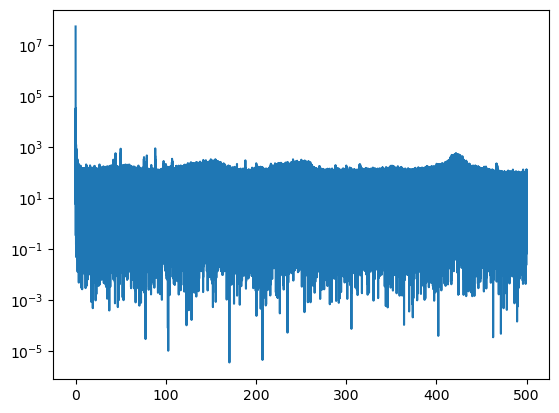

In [15]:
yf = rfft(gsr_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

In [16]:
lowpassfilter=signal.butter(N=10, Wn=2, btype='lp', fs=1000, output='sos')
gsr_filtered = signal.sosfilt(lowpassfilter, gsr_signal_notfiltered)

Comprobamos la senal filtrada. No deberia tener (o tener amplitud muy reducida) en las frecuencias a partir de los 2 Hz. Efectivamente vemos que se ha hecho lo mejor que se ha podido, y se han reducido notablemente las frecuencias mayores a 2 Hz. 

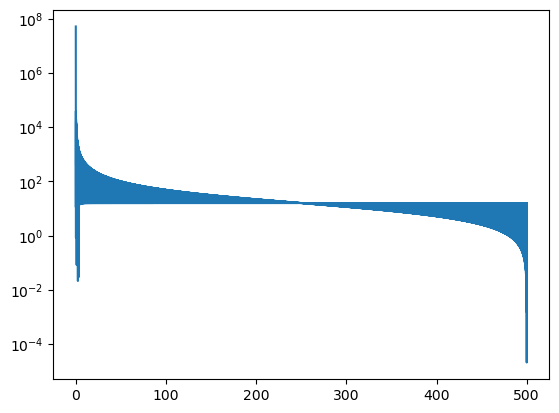

In [17]:
yf = rfft(gsr_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

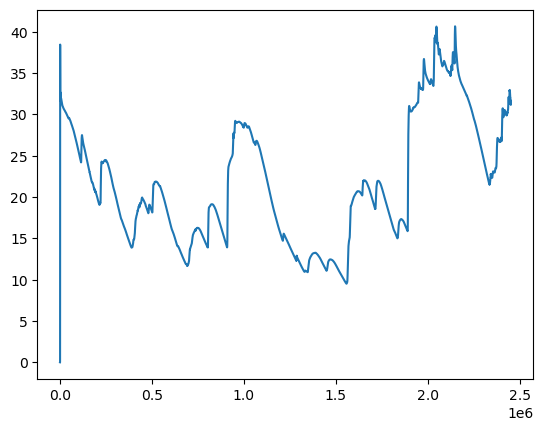

In [18]:
plt.plot(gsr_filtered)

In [19]:
gsr_signal_filtered = pd.DataFrame(gsr_filtered)
gsr_signal_filtered=gsr_signal_filtered.round(3)
gsr_signal_filtered=gsr_signal_filtered.rename(columns={0: "gsr"})
gsr_signal_filtered

gsr
0         0.000
1         0.000
2         0.000
3         0.000
4         0.000
...         ...
2451579  31.634
2451580  31.635
2451581  31.635
2451582  31.636
2451583  31.636

[2451584 rows x 1 columns]

B) Se pasa filtro de cuarto orden butterworth con frecuencias corte [30, 200] Hz a señal BVP.

<AxesSubplot:>

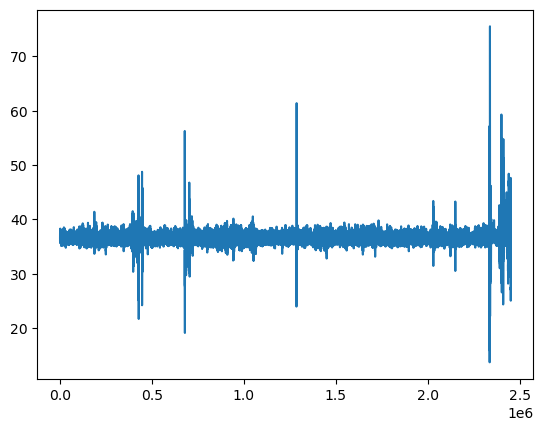

In [20]:
bvp_signal_notfiltered=df2['bvp']
bvp_signal_notfiltered.plot()

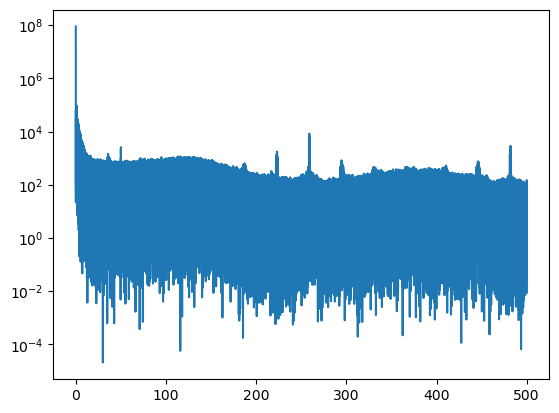

In [21]:
yf = rfft(bvp_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

Configuramos el filtro Butter con frecuencias de corte de 30 a 200 Hz, de cuarto orden. Es un filtro paso banda.

In [22]:
butterfilter=signal.butter(N=4, Wn=[30,200], btype='bandpass', fs=1000, output='sos')
bvp_filtered = signal.sosfilt(butterfilter, bvp_signal_notfiltered)

Comprobamos la senal filtrada. No deberia tener (o tener amplitud muy reducida) en las frecuencias menores de 30 Hz y mayores a 200 Hz. Efectivamente vemos que se ha hecho lo mejor que se ha podido, y se han reducido notablemente esas frecuencias.

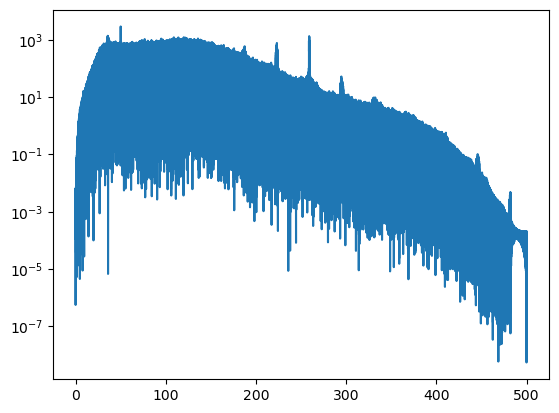

In [23]:
yf = rfft(bvp_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

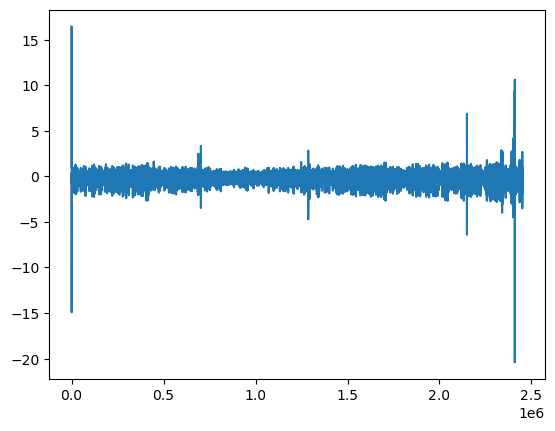

In [24]:
plt.plot(bvp_filtered)

Vemos que el paso banda está centrado en el 0, por lo que lo offseteamos a arriba. Este problema le pasa a más gente, así que no pasa nada. Luego, como normalizaremos los datos, este efecto se eliminará lo offseteemos lo que lo offseteemos.

In [25]:
bvp_signal_filtered = pd.DataFrame(bvp_filtered)
bvp_signal_filtered=bvp_signal_filtered.round(3)
bvp_signal_filtered=bvp_signal_filtered.rename(columns={0: "bvp"})
bvp_signal_filtered=bvp_signal_filtered.add(37)
bvp_signal_filtered

bvp
0        38.015
1        42.666
2        50.328
3        53.459
4        46.160
...         ...
2451579  37.061
2451580  36.961
2451581  36.916
2451582  36.944
2451583  36.987

[2451584 rows x 1 columns]

    C) Se utiliza un filtro de paso eliptico con frecuencias corte [0.005, 0.1] a señal ST (SKT).

<AxesSubplot:>

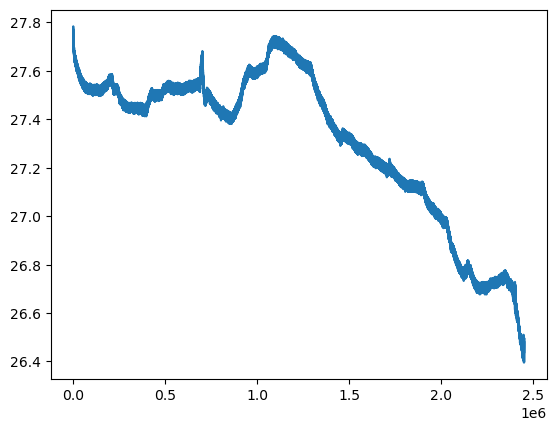

In [26]:
skt_signal_notfiltered=df2['skt']
skt_signal_notfiltered.plot()

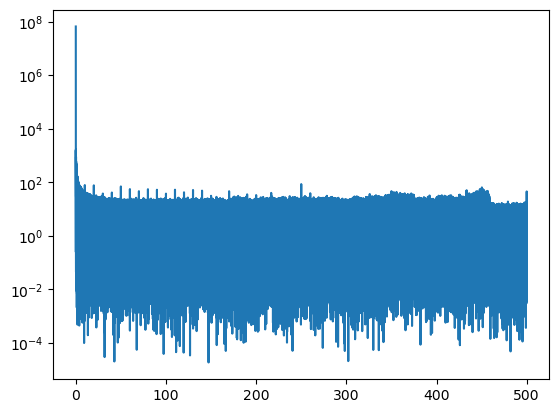

In [27]:
yf = rfft(skt_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

Configuramos nuestro filtro eliptico con frecuencias corte [0.005, 0.1] a señal skt.

In [28]:
ellipticfilter=signal.ellip(N=4,rp=1, rs=1, Wn=[0.005,0.1], btype='bandpass', fs=1000, output='sos')
skt_filtered = signal.sosfilt(ellipticfilter, skt_signal_notfiltered)

Comprobamos la senal filtrada. Algo ha filtrado.

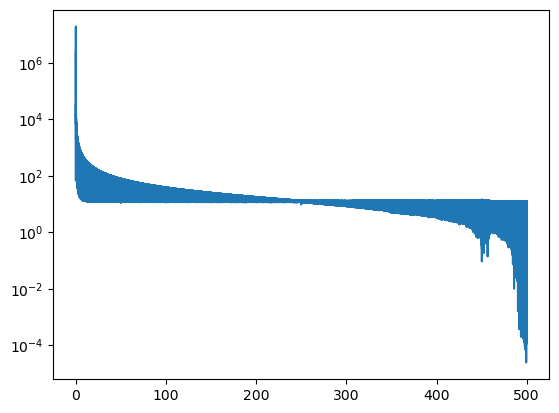

In [29]:
yf = rfft(skt_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

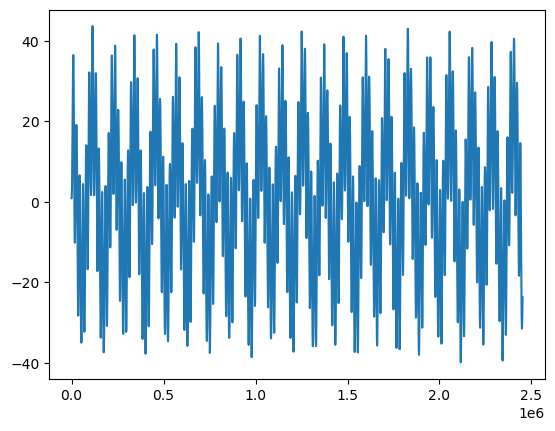

In [30]:
plt.plot(skt_filtered)

Vemos que el paso banda está centrado en el 0, por lo que lo offseteamos a arriba. Este problema le pasa a más gente, así que no pasa nada. Luego, como normalizaremos los datos, este efecto se eliminará lo offseteemos lo que lo offseteemos.

In [31]:
skt_signal_filtered = pd.DataFrame(skt_filtered)
skt_signal_filtered=skt_signal_filtered.round(3)
skt_signal_filtered=skt_signal_filtered.rename(columns={0: "skt"})
skt_signal_filtered=skt_signal_filtered.add(40)
skt_signal_filtered

skt
0        40.890
1        40.890
2        40.890
3        40.890
4        40.890
...         ...
2451579  16.257
2451580  16.263
2451581  16.266
2451582  16.271
2451583  16.276

[2451584 rows x 1 columns]

D) Se normalizan las senales.

Antes de normalizarlas, vamos a borrar las primeras 5000, ya que por los filtrados los principios de las senales son un poco raros. Borramos las columnas que acabamos de tunear del dataframe con todo.

In [32]:
df2=df2.drop(columns=["skt","bvp","gsr"])
df2

time    ecg     rsp  emg_zygo  emg_coru  emg_trap  video
0              0  1.030  33.641     7.987     7.124    11.641     10
1              1  1.043  33.621     7.946     7.083    11.641     10
2              2  1.053  33.640     7.986     7.164    11.723     10
3              3  1.047  33.669     8.108     7.206    11.723     10
4              4  1.043  33.650     8.109     7.084    11.561     10
...          ...    ...     ...       ...       ...       ...    ...
2451579  2451579  1.247  35.054     5.771     7.452    60.985     12
2451580  2451580  1.175  35.140     5.972     7.574    59.338     12
2451581  2451581  1.126  35.064     5.933     7.454    57.370     12
2451582  2451582  1.005  35.063     5.811     7.412    55.642     12
2451583  2451583  0.958  35.092     5.932     7.452    54.324     12

[2451584 rows x 7 columns]

In [33]:
df2=pd.concat([df2, bvp_signal_filtered, gsr_signal_filtered,skt_signal_filtered], axis=1)
df2

time    ecg     rsp  emg_zygo  emg_coru  emg_trap  video     bvp  \
0              0  1.030  33.641     7.987     7.124    11.641     10  38.015   
1              1  1.043  33.621     7.946     7.083    11.641     10  42.666   
2              2  1.053  33.640     7.986     7.164    11.723     10  50.328   
3              3  1.047  33.669     8.108     7.206    11.723     10  53.459   
4              4  1.043  33.650     8.109     7.084    11.561     10  46.160   
...          ...    ...     ...       ...       ...       ...    ...     ...   
2451579  2451579  1.247  35.054     5.771     7.452    60.985     12  37.061   
2451580  2451580  1.175  35.140     5.972     7.574    59.338     12  36.961   
2451581  2451581  1.126  35.064     5.933     7.454    57.370     12  36.916   
2451582  2451582  1.005  35.063     5.811     7.412    55.642     12  36.944   
2451583  2451583  0.958  35.092     5.932     7.452    54.324     12  36.987   

            gsr     skt  
0         0.000  40.890  
1         0.000  40.890  
2         0.000  40.890  
3         0.000  40.890  
4         0.000  40.890  
...         ...     ...  
2451579  31.634  16.257  
2451580  31.635  16.263  
2451581  31.635  16.266  
2451582  31.636  16.271  
2451583  31.636  16.276  

[2451584 rows x 10 columns]

Tras aclarar esto, ya pasamos a normalizar. Antes, quitamos los videos que van al train, para que se normalicen solo los datos que van a ser entrenados realmente (sin los videos de BlueScreen, EndVid y StartVid).

In [34]:
df2 = df2[df2.video != 10]
df2 = df2[df2.video != 11]
df2 = df2[df2.video != 12]
scaler = MinMaxScaler()
scaler.fit(df2)
normalized = pd.DataFrame(scaler.transform(df2), index=df2.index, columns=df2.columns)
df2_normalized = pd.DataFrame(normalized, columns=df2.columns)
df2_normalized=df2_normalized.drop(columns=["video","time"])
numvideo_bien = df2["video"] 
tiempo_bien=df2["time"] 
df2_normalized=df2_normalized.join(numvideo_bien)
df2_normalized=df2_normalized.join(tiempo_bien)
df2=df2_normalized[["time","ecg","bvp","gsr","skt","rsp","emg_zygo","emg_coru","emg_trap","video"]]
df2

time       ecg       bvp       gsr       skt       rsp  emg_zygo  \
221501    221501  0.524191  0.481607  0.341848  0.793009  0.993329  0.031498   
221502    221502  0.526113  0.476180  0.341915  0.792933  0.995039  0.031046   
221503    221503  0.521948  0.473014  0.341982  0.792858  0.993500  0.030120   
221504    221504  0.534444  0.477612  0.342050  0.792782  1.000000  0.031035   
221505    221505  0.528356  0.483944  0.342117  0.792706  0.995039  0.030120   
...          ...       ...       ...       ...       ...       ...       ...   
2331579  2331579  0.509452  0.472712  0.365240  0.357251  0.569620  0.033823   
2331580  2331580  0.514579  0.478366  0.365240  0.357339  0.567910  0.032909   
2331581  2331581  0.503364  0.484396  0.365240  0.357427  0.572870  0.033812   
2331582  2331582  0.509452  0.487562  0.365240  0.357503  0.567910  0.033823   
2331583  2331583  0.515540  0.485602  0.365240  0.357591  0.571160  0.033360   

         emg_coru  emg_trap  video  
221501   0.017651  0.033339      4  
221502   0.020605  0.033040      4  
221503   0.016246  0.032718      4  
221504   0.020605  0.033032      4  
221505   0.017723  0.033032      4  
...           ...       ...    ...  
2331579  0.019128  0.027669      1  
2331580  0.019164  0.026749      1  
2331581  0.020605  0.027983      1  
2331582  0.017723  0.028312      1  
2331583  0.019128  0.029561      1  

[1270083 rows x 10 columns]

    E) Frecuencia común 50 Hz

Para la frecuencia comun a ambos, ello implica tener lecturas cada 1/50 = 20 ms. Para las senales fisiologicas lo tenemos, pero para las annotations no, por lo que hay que resample. Primero resampleamos a que nos saque todos los valores por milisegundo de annotations, y luego downsampleamos para quedarnos solo con los que sean menores a 20 ms. 

In [35]:
n_samples=length_orig_df2
df1_clean=df1.drop(columns=['time', 'video'])
array1_resampled=signal.resample(df1_clean, n_samples)
df1_resampled=pd.DataFrame(array1_resampled,columns=["valence","arousal"])
df1_resampled=df1_resampled.round(3)
print(df1_resampled)

         valence  arousal
0            5.0      5.0
1            5.0      5.0
2            5.0      5.0
3            5.0      5.0
4            5.0      5.0
...          ...      ...
2451579      5.0      5.0
2451580      5.0      5.0
2451581      5.0      5.0
2451582      5.0      5.0
2451583      5.0      5.0

[2451584 rows x 2 columns]


Unimos los csv, con columna intersección en "time". Borramos los instantes de tiempo X e Y porque en realidad no son necesarios. Reordenamos las columnas.

In [36]:
df3=pd.merge(df1_resampled, df2, left_index=True, right_index=True)

columnsTitles = ['time', 'ecg', 'bvp','gsr','rsp','skt','emg_zygo','emg_coru','emg_trap','valence','arousal','video']
df3 = df3.reindex(columns=columnsTitles)

print(df3)

            time       ecg       bvp       gsr       rsp       skt  emg_zygo  \
221501    221501  0.524191  0.481607  0.341848  0.993329  0.793009  0.031498   
221502    221502  0.526113  0.476180  0.341915  0.995039  0.792933  0.031046   
221503    221503  0.521948  0.473014  0.341982  0.993500  0.792858  0.030120   
221504    221504  0.534444  0.477612  0.342050  1.000000  0.792782  0.031035   
221505    221505  0.528356  0.483944  0.342117  0.995039  0.792706  0.030120   
...          ...       ...       ...       ...       ...       ...       ...   
2331579  2331579  0.509452  0.472712  0.365240  0.569620  0.357251  0.033823   
2331580  2331580  0.514579  0.478366  0.365240  0.567910  0.357339  0.032909   
2331581  2331581  0.503364  0.484396  0.365240  0.572870  0.357427  0.033812   
2331582  2331582  0.509452  0.487562  0.365240  0.567910  0.357503  0.033823   
2331583  2331583  0.515540  0.485602  0.365240  0.571160  0.357591  0.033360   

         emg_coru  emg_trap  valence  a

Downsampleamos a 20 ms y eliminamos la columna tiempo. 

In [37]:
df3 = df3.drop(df3[df3.time%20 != 0].index)
df3 = df3.drop(columns=['time'])
print(df3)

              ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
221520   0.527395  0.487185  0.343125  1.000000  0.791560  0.023629  0.016210   
221540   0.501121  0.483718  0.344469  0.985118  0.790010  0.023166  0.016210   
221560   0.461070  0.481984  0.345780  0.995039  0.788485  0.028709  0.022046   
221580   0.444409  0.470300  0.347125  0.980157  0.786935  0.026417  0.013293   
221600   0.451458  0.483492  0.348435  0.985118  0.785397  0.032886  0.020605   
...           ...       ...       ...       ...       ...       ...       ...   
2331500  0.514899  0.471732  0.365509  0.574410  0.350711  0.040766  0.020605   
2331520  0.520987  0.479723  0.365442  0.572870  0.352374  0.044052  0.011852   
2331540  0.502083  0.482889  0.365375  0.562949  0.354025  0.039389  0.017687   
2331560  0.509452  0.473918  0.365308  0.567910  0.355688  0.040778  0.014769   
2331580  0.514579  0.478366  0.365240  0.567910  0.357339  0.032909  0.019164   

         emg_trap  valence 

Creamos la ventana de n = 2 segundos. Una ventana de datos simplemente será concatenar los datos dentro de grupos de 2 segundos, haciendo la media de valencia y de arousal de todos ellos. 

Como la frecuencia de muestreo son 20 ms, cada ventana de 2 segundos tendrá en total 100 observaciones. Después, esto lo "flattenaremos" para que el modelo ML en R pueda tragarlo.  

En primer lugar, como las ventanas son de 2 segundos, eliminamos un número de datos para que nos den las ventanas justas. Tendríamos varios criterios:

- A) Ver en el completo de los datos las entradas que tenemos múltiplos de 100 (ventanas de 2 s), y eliminar del múltiplo más alto hasta el final.

- B) Algo más fino quizá sería hacer lo mismo pero video a video. 

Por simplicidad y ver lo que sale hacemos A). Comenzamos creando un nuevo indice desde 0 del Dataframe que tenemos y borramos el valor del video. 

In [38]:
df3 = df3.drop(columns=['video'])
df3 = df3.reset_index()
df3 = df3.drop(columns=['index'])
df3

ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
0      0.527395  0.487185  0.343125  1.000000  0.791560  0.023629  0.016210   
1      0.501121  0.483718  0.344469  0.985118  0.790010  0.023166  0.016210   
2      0.461070  0.481984  0.345780  0.995039  0.788485  0.028709  0.022046   
3      0.444409  0.470300  0.347125  0.980157  0.786935  0.026417  0.013293   
4      0.451458  0.483492  0.348435  0.985118  0.785397  0.032886  0.020605   
...         ...       ...       ...       ...       ...       ...       ...   
63499  0.514899  0.471732  0.365509  0.574410  0.350711  0.040766  0.020605   
63500  0.520987  0.479723  0.365442  0.572870  0.352374  0.044052  0.011852   
63501  0.502083  0.482889  0.365375  0.562949  0.354025  0.039389  0.017687   
63502  0.509452  0.473918  0.365308  0.567910  0.355688  0.040778  0.014769   
63503  0.514579  0.478366  0.365240  0.567910  0.357339  0.032909  0.019164   

       emg_trap  valence  arousal  
0      0.038695     5.00    5.000  
1      0.033032     5.00    5.000  
2      0.033960     5.00    5.000  
3      0.033354     5.00    5.000  
4      0.033017     5.00    5.000  
...         ...      ...      ...  
63499  0.044357     7.56    5.887  
63500  0.041530     7.56    5.887  
63501  0.043737     7.56    5.887  
63502  0.029899     7.56    5.887  
63503  0.026749     7.56    5.887  

[63504 rows x 10 columns]

Como tenemos 63504 filas, necesitamos borrar solo las ultimas 4.

In [39]:
df3=df3.drop([63503, 63502, 63501, 63500])
df3

ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
0      0.527395  0.487185  0.343125  1.000000  0.791560  0.023629  0.016210   
1      0.501121  0.483718  0.344469  0.985118  0.790010  0.023166  0.016210   
2      0.461070  0.481984  0.345780  0.995039  0.788485  0.028709  0.022046   
3      0.444409  0.470300  0.347125  0.980157  0.786935  0.026417  0.013293   
4      0.451458  0.483492  0.348435  0.985118  0.785397  0.032886  0.020605   
...         ...       ...       ...       ...       ...       ...       ...   
63495  0.504326  0.486884  0.365745  0.577831  0.344057  0.055635  0.016246   
63496  0.510413  0.484999  0.365677  0.572870  0.345721  0.043081  0.023523   
63497  0.509452  0.487336  0.365610  0.572870  0.347384  0.045869  0.019128   
63498  0.515540  0.484321  0.365543  0.572870  0.349047  0.051909  0.019128   
63499  0.514899  0.471732  0.365509  0.574410  0.350711  0.040766  0.020605   

       emg_trap  valence  arousal  
0      0.038695     5.00    5.000  
1      0.033032     5.00    5.000  
2      0.033960     5.00    5.000  
3      0.033354     5.00    5.000  
4      0.033017     5.00    5.000  
...         ...      ...      ...  
63495  0.028328     7.56    5.887  
63496  0.033645     7.56    5.887  
63497  0.028320     7.56    5.887  
63498  0.026106     7.56    5.887  
63499  0.044357     7.56    5.887  

[63500 rows x 10 columns]

Y ahora si, con split dividimos el Dataset en 635 entradas de 100 datos cada una. 

In [40]:
df3_split_2s = np.array_split(df3, len(df3)/25)
df3_split_2s

[         ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
 0   0.527395  0.487185  0.343125  1.000000  0.791560  0.023629  0.016210   
 1   0.501121  0.483718  0.344469  0.985118  0.790010  0.023166  0.016210   
 2   0.461070  0.481984  0.345780  0.995039  0.788485  0.028709  0.022046   
 3   0.444409  0.470300  0.347125  0.980157  0.786935  0.026417  0.013293   
 4   0.451458  0.483492  0.348435  0.985118  0.785397  0.032886  0.020605   
 5   0.485101  0.483642  0.349746  0.976907  0.783835  0.034760  0.014733   
 6   0.684076  0.480703  0.351057  0.980157  0.782297  0.030109  0.020605   
 7   0.292534  0.474144  0.352368  0.975197  0.780748  0.028269  0.017687   
 8   0.286126  0.476255  0.353645  0.971947  0.779185  0.026395  0.019128   
 9   0.426145  0.484019  0.354956  0.971947  0.777635  0.027806  0.019200   
 10  0.452740  0.483265  0.356267  0.970236  0.776072  0.024532  0.016210   
 11  0.479974  0.486658  0.357544  0.970236  0.774522  0.024092  0.017723   

Ahora, realizaremos el Flatteneado. Las matrices las haremos una linea continua: pasamos de tener 100 observaciones de 8 variables a tener 1 observacion de 800 variables. 
Creamos el Dataframe que nos contenga todo, que tendrá 800 variables + Valence + Arousal (802 en total). Le ponemos nombre a las columnas del Dataframe solamente porque no se puede crear un Dataframe sin columnas, sino solo nos importaría llamar a la de Valence y Arousal.  

In [41]:
list_array = list(np.arange(1,201))
list_array.append("valence")
list_array.append("arousal")
df4 = pd.DataFrame(columns=list_array)
df4

Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, ...]
Index: []

[0 rows x 202 columns]

Y ahora hago el proceso de hacer el flatenning, y obtener el nuevo Dataframe con la ventana aplicada que exportaremos. Lo hacemos con un for para que repase todas las agrupaciones de 8 x 100 datos. De cada ventana calculamos (según papers) la valence y arousal promedios, y eso lo anadiremos en las ultimas dos columnas). 

In [42]:
for entrada in df3_split_2s:
    ave_valence=entrada['valence'].mean()
    ave_arousal=entrada['arousal'].mean()
    entrada=entrada.drop(columns=['valence','arousal'])
    a=entrada.to_numpy().flatten()
    a=np.append(a, ave_valence)
    a=np.append(a, ave_arousal)
    df4.loc[len(df4)] = a

In [43]:
df4

1         2         3         4         5         6         7  \
0     0.527395  0.487185  0.343125  1.000000  0.791560  0.023629  0.016210   
1     0.489587  0.483869  0.373509  0.950393  0.752558  0.035675  0.014697   
2     0.470362  0.483869  0.395254  0.875813  0.713342  0.022681  0.014661   
3     0.481897  0.477612  0.413673  0.829456  0.675223  0.018978  0.011744   
4     0.487344  0.482889  0.426612  0.817824  0.639347  0.019440  0.011744   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.525152  0.493743  0.373374  0.485118  0.165822  0.019926  0.014733   
2536  0.491509  0.490804  0.371761  0.433801  0.196053  0.053772  0.014733   
2537  0.520987  0.481456  0.370181  0.395655  0.231047  0.064373  0.010303   
2538  0.498879  0.482662  0.368635  0.437051  0.269721  0.053286  0.023523   
2539  0.352451  0.488467  0.367022  0.531475  0.310676  0.065806  0.017651   

             8         9        10  ...       193       194       195  \
0     0.038695  0.501121  0.483718  ...  0.495674  0.476029  0.372534   
1     0.028941  0.490548  0.480552  ...  0.428388  0.483416  0.394380   
2     0.041844  0.481897  0.478667  ...  0.484140  0.477687  0.412967   
3     0.031140  0.479974  0.464043  ...  0.480936  0.481079  0.426142   
4     0.029577  0.488305  0.480326  ...  0.467478  0.493743  0.436090   
...        ...       ...       ...  ...       ...       ...       ...   
2535  0.040281  0.516822  0.483190  ...  0.489587  0.479949  0.371794   
2536  0.015103  0.491509  0.481004  ...  0.517783  0.476104  0.370248   
2537  0.021087  0.534764  0.476934  ...  0.498879  0.485452  0.368702   
2538  0.023271  0.508170  0.484773  ...  0.254726  0.485150  0.367089   
2539  0.068563  0.468119  0.492914  ...  0.514899  0.471732  0.365509   

           196       197       198       199       200  valence  arousal  
0     0.943722  0.754121  0.042640  0.010303  0.033354     5.00    5.000  
1     0.884194  0.714892  0.025017  0.008826  0.050671     5.00    5.000  
2     0.831167  0.676723  0.017612  0.016246  0.031783     5.00    5.000  
3     0.813035  0.640720  0.020389  0.008826  0.030205     5.00    5.000  
4     0.768218  0.607843  0.039852  0.016210  0.029891     5.00    5.000  
...        ...       ...       ...       ...       ...      ...      ...  
2535  0.427301  0.194743  0.044503  0.011816  0.015731     7.56    5.887  
2536  0.395655  0.229573  0.048658  0.013256  0.025799     7.56    5.887  
2537  0.428840  0.268108  0.072309  0.019164  0.026113     7.56    5.887  
2538  0.529935  0.309013  0.068132  0.019128  0.030190     7.56    5.887  
2539  0.574410  0.350711  0.040766  0.020605  0.044357     7.56    5.887  

[2540 rows x 202 columns]

Para esta iteracion, analizamos los datos segun CorrNet. CorrNet propone 3 clasificaciones diferentes:
- Clasificación en 2 clases:
    
    Modelo ML A: Clasificamos Arousal en High y Low.
    
    Modelo ML B: Clasificamos Valence en High y Low. 


- Clasificación en 3 clases:
    
    Modelo ML C: Clasificamos Arousal en High, Neutral y Low.
   
    Modelo ML D: Clasificamos Valence en High, Neutral y Low.
    
    
- Clasificación en 4 clases:
    
    Modelo ML E: Clasificamos Valence y Arousal en los cuatro cuadrantes: High High, High Low, Low Low y Low High. 
   
   
Para cada uno, realizamos un dataframe diferente. 

- Modelo A. Clasificamos Arousal en High y Low. High --> 2 y Low --> 1

In [44]:
df4_A = df4.drop(columns=['valence'])
df4_A=df4_A.rename(columns={"arousal": "auxiliar"})
df4_A.loc[df4_A['auxiliar'] < 5, 'arousal'] = 1
df4_A.loc[df4_A['auxiliar'] >= 5, 'arousal'] = 2
df4_A = df4_A.drop(columns=['auxiliar'])
print(df4_A)

             1         2         3         4         5         6         7  \
0     0.527395  0.487185  0.343125  1.000000  0.791560  0.023629  0.016210   
1     0.489587  0.483869  0.373509  0.950393  0.752558  0.035675  0.014697   
2     0.470362  0.483869  0.395254  0.875813  0.713342  0.022681  0.014661   
3     0.481897  0.477612  0.413673  0.829456  0.675223  0.018978  0.011744   
4     0.487344  0.482889  0.426612  0.817824  0.639347  0.019440  0.011744   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.525152  0.493743  0.373374  0.485118  0.165822  0.019926  0.014733   
2536  0.491509  0.490804  0.371761  0.433801  0.196053  0.053772  0.014733   
2537  0.520987  0.481456  0.370181  0.395655  0.231047  0.064373  0.010303   
2538  0.498879  0.482662  0.368635  0.437051  0.269721  0.053286  0.023523   
2539  0.352451  0.488467  0.367022  0.531475  0.310676  0.065806  0.017651   

             8         9        10  ...       192       193    

In [45]:
df4_A.to_csv('Output/arousal_2_clases_sub4.csv', index=False)

- Modelo B. Clasificamos Valence en High y Low. High --> 2 y Low --> 1

In [46]:
df4_B = df4.drop(columns=['arousal'])
df4_B=df4_B.rename(columns={"valence": "auxiliar"})
df4_B.loc[df4_B['auxiliar'] < 5, 'valence'] = 1
df4_B.loc[df4_B['auxiliar'] >= 5, 'valence'] = 2
df4_B = df4_B.drop(columns=['auxiliar'])
print(df4_B)

             1         2         3         4         5         6         7  \
0     0.527395  0.487185  0.343125  1.000000  0.791560  0.023629  0.016210   
1     0.489587  0.483869  0.373509  0.950393  0.752558  0.035675  0.014697   
2     0.470362  0.483869  0.395254  0.875813  0.713342  0.022681  0.014661   
3     0.481897  0.477612  0.413673  0.829456  0.675223  0.018978  0.011744   
4     0.487344  0.482889  0.426612  0.817824  0.639347  0.019440  0.011744   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.525152  0.493743  0.373374  0.485118  0.165822  0.019926  0.014733   
2536  0.491509  0.490804  0.371761  0.433801  0.196053  0.053772  0.014733   
2537  0.520987  0.481456  0.370181  0.395655  0.231047  0.064373  0.010303   
2538  0.498879  0.482662  0.368635  0.437051  0.269721  0.053286  0.023523   
2539  0.352451  0.488467  0.367022  0.531475  0.310676  0.065806  0.017651   

             8         9        10  ...       192       193    

In [47]:
df4_B.to_csv('Output/valence_2_clases_sub4.csv', index=False)

- Modelo C. Clasificamos Arousal en High, Neutral y Low. High --> 3, Neutral --> 2 y Low --> 1

In [48]:
df4_C = df4.drop(columns=['valence'])
df4_C=df4_C.rename(columns={"arousal": "auxiliar"})
df4_C.loc[df4_C['auxiliar'] < 3, 'arousal'] = 1
df4_C.loc[(df4_C['auxiliar'] >= 3) & (df4_C['auxiliar'] < 6), 'arousal'] = 2
df4_C.loc[(df4_C['auxiliar'] >= 6), 'arousal'] = 3
df4_C = df4_C.drop(columns=['auxiliar'])
print(df4_C)

             1         2         3         4         5         6         7  \
0     0.527395  0.487185  0.343125  1.000000  0.791560  0.023629  0.016210   
1     0.489587  0.483869  0.373509  0.950393  0.752558  0.035675  0.014697   
2     0.470362  0.483869  0.395254  0.875813  0.713342  0.022681  0.014661   
3     0.481897  0.477612  0.413673  0.829456  0.675223  0.018978  0.011744   
4     0.487344  0.482889  0.426612  0.817824  0.639347  0.019440  0.011744   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.525152  0.493743  0.373374  0.485118  0.165822  0.019926  0.014733   
2536  0.491509  0.490804  0.371761  0.433801  0.196053  0.053772  0.014733   
2537  0.520987  0.481456  0.370181  0.395655  0.231047  0.064373  0.010303   
2538  0.498879  0.482662  0.368635  0.437051  0.269721  0.053286  0.023523   
2539  0.352451  0.488467  0.367022  0.531475  0.310676  0.065806  0.017651   

             8         9        10  ...       192       193    

In [49]:
df4_C.to_csv('Output/arousal_3_clases_sub4.csv', index=False)

- Modelo D. Clasificamos Valence en High, Neutral y Low. High --> 3, Neutral --> 2 y Low --> 1

In [50]:
df4_D = df4.drop(columns=['arousal'])
df4_D=df4_D.rename(columns={"valence": "auxiliar"})
df4_D.loc[df4_D['auxiliar'] < 3, 'valence'] = 1
df4_D.loc[(df4_D['auxiliar'] >= 3) & (df4_D['auxiliar'] < 6), 'valence'] = 2
df4_D.loc[(df4_D['auxiliar'] >= 6), 'valence'] = 3
df4_D = df4_D.drop(columns=['auxiliar'])
print(df4_D)

             1         2         3         4         5         6         7  \
0     0.527395  0.487185  0.343125  1.000000  0.791560  0.023629  0.016210   
1     0.489587  0.483869  0.373509  0.950393  0.752558  0.035675  0.014697   
2     0.470362  0.483869  0.395254  0.875813  0.713342  0.022681  0.014661   
3     0.481897  0.477612  0.413673  0.829456  0.675223  0.018978  0.011744   
4     0.487344  0.482889  0.426612  0.817824  0.639347  0.019440  0.011744   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.525152  0.493743  0.373374  0.485118  0.165822  0.019926  0.014733   
2536  0.491509  0.490804  0.371761  0.433801  0.196053  0.053772  0.014733   
2537  0.520987  0.481456  0.370181  0.395655  0.231047  0.064373  0.010303   
2538  0.498879  0.482662  0.368635  0.437051  0.269721  0.053286  0.023523   
2539  0.352451  0.488467  0.367022  0.531475  0.310676  0.065806  0.017651   

             8         9        10  ...       192       193    

In [51]:
df4_D.to_csv('Output/valence_3_clases_sub4.csv', index=False)

- Modelo E. Clasificamos Valence y Arousal. Valence High y Arousal High --> 4, Valence High y Arousal Low --> 3, Valence Low y Arousal High --> 2, Valence Low y Arousal Low --> 1. 

In [52]:
df4_E = df4
df4_E.loc[(df4_E['valence'] <= 5) & (df4_E['arousal'] <= 5), 'valencearousal'] = 1
df4_E.loc[(df4_E['valence'] <= 5) & (df4_E['arousal'] > 5), 'valencearousal'] = 2
df4_E.loc[(df4_E['valence'] > 5) & (df4_E['arousal'] <= 5), 'valencearousal'] = 3
df4_E.loc[(df4_E['valence'] > 5) & (df4_E['arousal'] > 5), 'valencearousal'] = 4
df4_E = df4_E.drop(columns=['valence', 'arousal'])
print(df4_E)

             1         2         3         4         5         6         7  \
0     0.527395  0.487185  0.343125  1.000000  0.791560  0.023629  0.016210   
1     0.489587  0.483869  0.373509  0.950393  0.752558  0.035675  0.014697   
2     0.470362  0.483869  0.395254  0.875813  0.713342  0.022681  0.014661   
3     0.481897  0.477612  0.413673  0.829456  0.675223  0.018978  0.011744   
4     0.487344  0.482889  0.426612  0.817824  0.639347  0.019440  0.011744   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.525152  0.493743  0.373374  0.485118  0.165822  0.019926  0.014733   
2536  0.491509  0.490804  0.371761  0.433801  0.196053  0.053772  0.014733   
2537  0.520987  0.481456  0.370181  0.395655  0.231047  0.064373  0.010303   
2538  0.498879  0.482662  0.368635  0.437051  0.269721  0.053286  0.023523   
2539  0.352451  0.488467  0.367022  0.531475  0.310676  0.065806  0.017651   

             8         9        10  ...       192       193    

In [53]:
df4_E.to_csv('Output/valencearousal_4_clases_sub4.csv', index=False)